[1] "Agriculture and Agri-Food Canada"                   
 [2] "Canada Border Services Agency"                      
 [3] "Canadian Food Inspection Agency"                    
 [4] "Immigration, Refugees and Citizenship Canada"       
 [5] "Canada Revenue Agency"                              
 [6] "Canada School of Public Service"                    
 [7] "Employment and Social Development Canada"           
 [8] "Innovation, Science and Economic Development Canada"
 [9] "Public Services and Procurement Canada"             
[10] "Shared Services Canada"                             
[11] "Veterans Affairs Canada"

[1] 1034   37

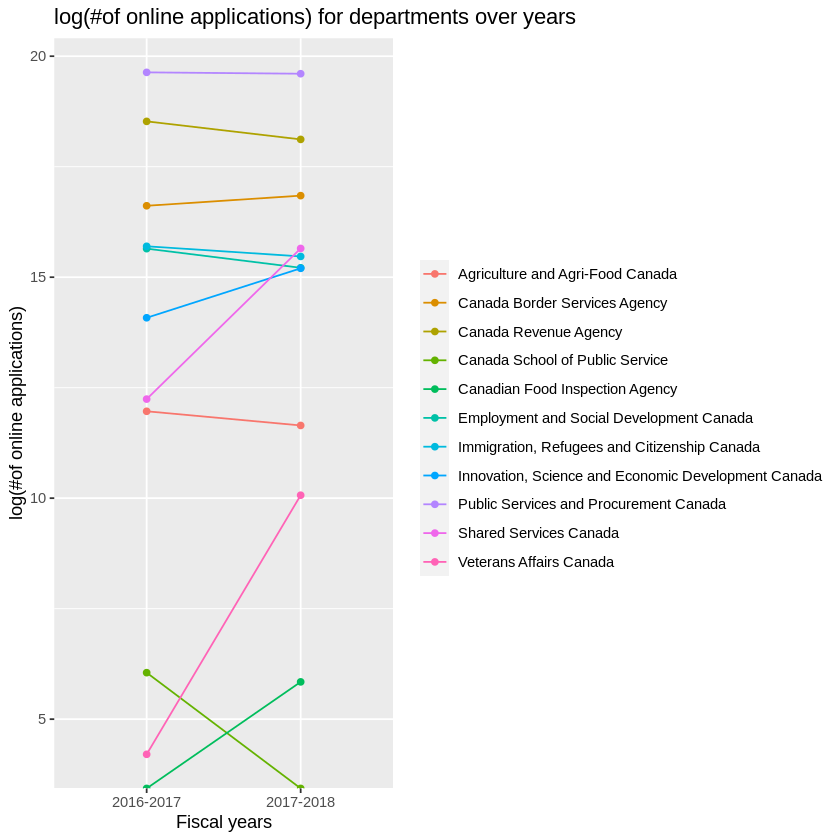

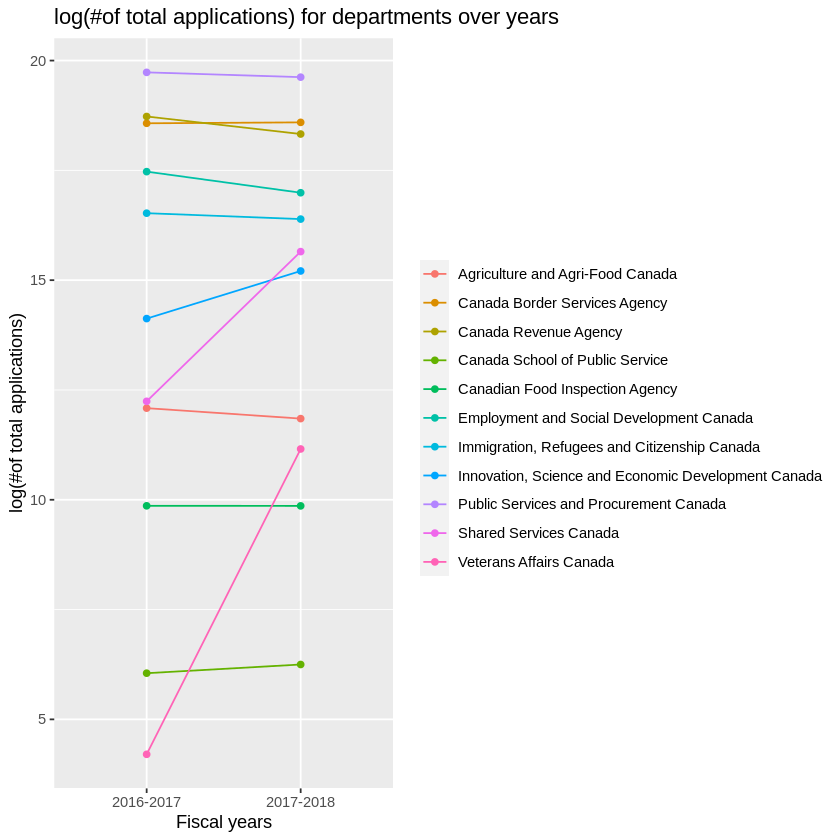

[1] "fiscal_yr"                "service_id"              
 [3] "service_name_en"          "service_name_fr"         
 [5] "department_name_en"       "department_name_fr"      
 [7] "external_internal"        "service_type"            
 [9] "special_designations"     "service_description_en"  
[11] "service_description_fr"   "service_url_en"          
[13] "service_url_fr"           "program_name_en"         
[15] "program_name_fr"          "last_GBA"                
[17] "client_target_groups"     "info_service"            
[19] "service_fee"              "cra_business_number"     
[21] "use_of_sin"               "service_channels"        
[23] "online_applications"      "web_visits_info_service" 
[25] "calls_received"           "in_person_applications"  
[27] "postal_mail_applications" "other_applications"      
[29] "e_registration"           "e_authentication"        
[31] "e_application"            "e_decision"              
[33] "e_issuance"               "e_feedback"              
[35] "client_feedback"          "special_remarks_en"      
[37] "special_remarks_fr"       "sum"

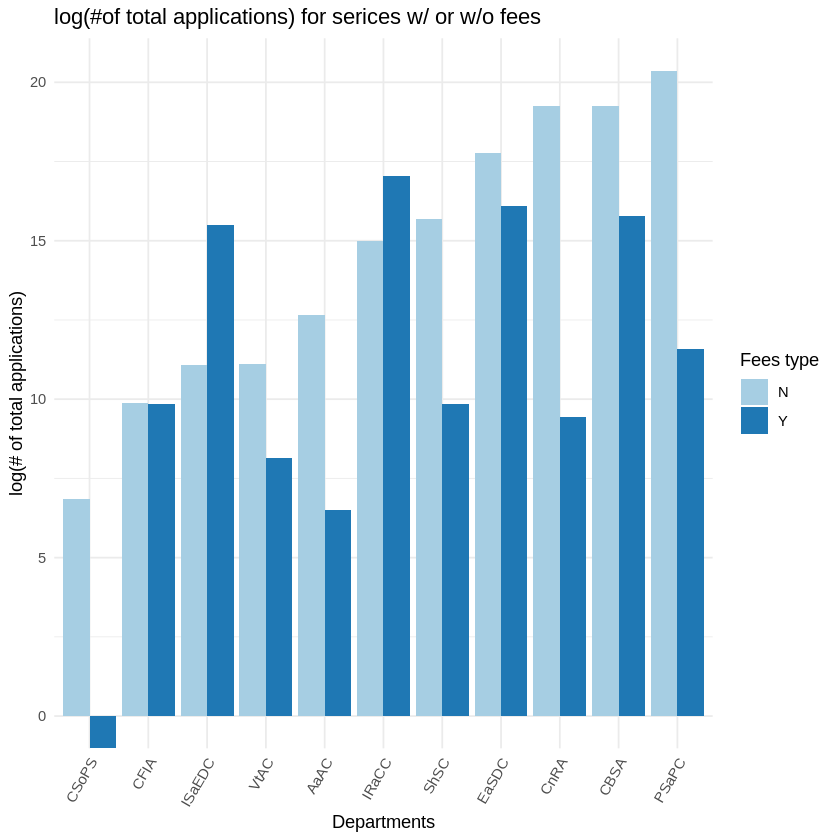

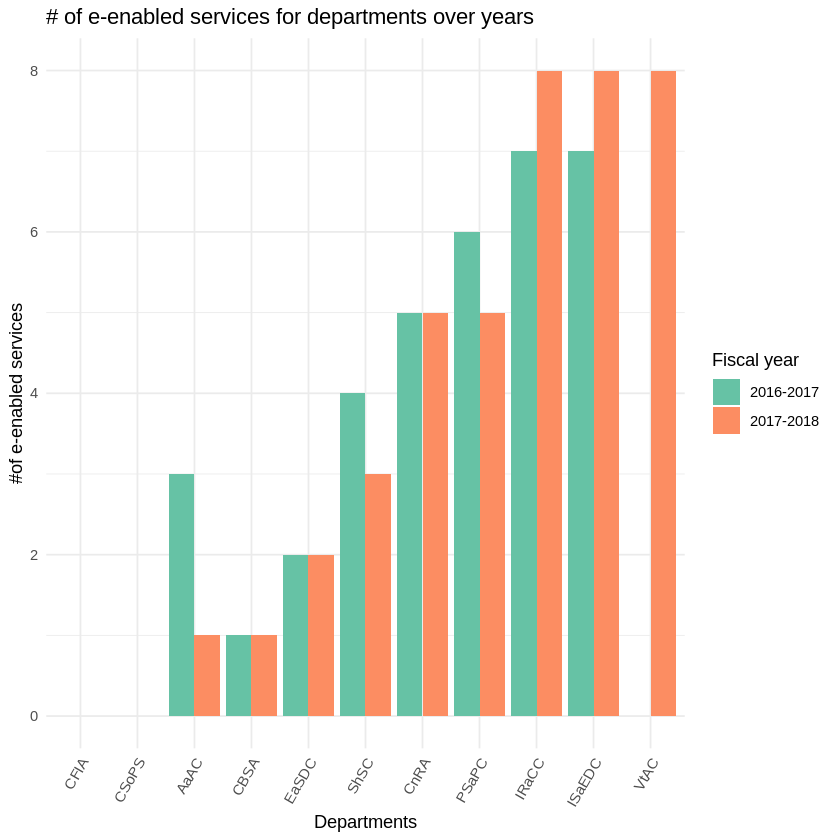

In [7]:
data = read.csv(url("https://open.canada.ca/data/dataset/3ac0d080-6149-499a-8b06-7ce5f00ec56c/resource/3acf79c0-a5f5-4d9a-a30d-fb5ceba4b60a/download/service_inventory.csv"), na.strings = c("ND", "NA"))

library(ggplot2)
data[,c(23:28)] = sapply( data[,c(23:28)], as.numeric )

# select 11 deparments with records in 3 fiscal years
data1=unique(data[which(data$fiscal_yr==data$fiscal_yr[1]),]$department_name_en)
data2=unique(data[which(data$fiscal_yr==data$fiscal_yr[2]),]$department_name_en)
data3=unique(data[which(data$fiscal_yr==data$fiscal_yr[3]),]$department_name_en)
inter=intersect(data1,data2)
dep=intersect(inter,data3)
dep
# only remain data with 11 departments
data=data[which(data$department_name_en %in% dep),]
dim(data) # 1865 to 1034 rows

# drop the last year because of large NDs
data=data[-which(data$fiscal_yr=="2018-2019"),]

# sum the number of online applications(can be anything) by departent and year
a=aggregate(data$online_applications, by=list(data$department_name_en, data$fiscal_yr), FUN=sum, na.rm=TRUE)
ggplot(a, aes(x=Group.2, y=log(x), group=Group.1, color=Group.1)) +
geom_line()+geom_point()+ggtitle("log(#of online applications) for departments over years")+
xlab("Fiscal years")+ylab("log(#of online applications)")+theme(legend.title = element_blank(), legend.position = "right", legend.background = element_rect(fill = "transparent"))

# compute total applications for each row
data[,38]=data$in_person_applications+data$postal_mail_applications+data$other_applications+data$online_applications
colnames(data)[38]="sum"
# sum the number of total applications by department and year
b=aggregate(data$sum, by=list(data$department_name_en, data$fiscal_yr), FUN=sum, na.rm=TRUE)
ggplot(b, aes(x=Group.2, y=log(x), group=Group.1, color=Group.1)) +
  geom_line()+geom_point()+ggtitle("log(#of total applications) for departments over years")+
  xlab("Fiscal years")+ylab("log(#of total applications)")+theme(legend.title = element_blank(), legend.position = "right", legend.background = element_rect(fill = "transparent"))

# log(number of applications) with or without fee
c=aggregate(data$sum, by=list(data$service_fee, data$department_name_en), FUN=sum, na.rm=TRUE)
row=c("Y","Canada School of Public Service",0)
cc=rbind(c[1:7,],row,c[8:21,])
cc$x=as.numeric(cc$x)
cc$Group.2 = factor(cc$Group.2, levels = unique(cc$Group.2)[order(cc[which(cc$Group.1=="N"),]$x)])
ggplot(cc,aes(x=Group.2, y=log(x), fill=Group.1))+ylab("log(# of total applications)")+xlab("Departments")+ggtitle("log(#of total applications) for serices w/ or w/o fees")+theme_minimal()+geom_bar(stat="identity",position=position_dodge())+labs(fill = "Fees type")+scale_fill_brewer(palette="Paired")+theme(axis.text.x = element_text(angle = 60, hjust=1))+scale_x_discrete(label=abbreviate)

#number of e-enabled services for each department
e=data[which(data$e_application=="Y" & data$e_authentication=="Y" & data$e_decision=="Y" & data$e_feedback=="Y" & data$e_issuance=="Y" & data$e_registration=="Y"),]
colnames(e)
count=matrix(0,11,2)
for(i in 1:11){
  for(j in 1:2){
    a=e[which(e$fiscal_yr==unique(data$fiscal_yr)[j]),5]
    count[i,j]=length(a[which(a==unique(data$department_name_en)[i])])
  }
}
number=c(count[,1],count[,2])
departments=c(rep(unique(data$department_name_en),2))
fiscal_yr=c(rep("2016-2017",11),rep("2017-2018",11))
data2=data.frame(departments,fiscal_yr,number)
data2$departments = factor(data2$departments, levels = unique(data2$departments)[order(data2[12:22,]$number)])
ggplot(data2, aes(x=departments, y=number, fill=fiscal_yr))+geom_bar(stat="identity",position=position_dodge())+xlab("Departments")+ylab("#of e-enabled services")+ggtitle("# of e-enabled services for departments over years")+labs(fill = "Fiscal year")+scale_x_discrete(label=abbreviate)+theme_minimal()+scale_fill_brewer(palette="Set2")+theme(axis.text.x = element_text(angle = 60, hjust=1))


